In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(20056, 28)
(20056, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where RL swings
idxs = np.where(X_motion[:, 23] == 1)[0]
X_motion_RL_swinging = X_motion[idxs]
Y_motion_RL_swinging = Y_motion[idxs]

## Predict RL foot -> x

In [8]:
X_motion_RL_swinging[0, :]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.98547262e-02,
       -1.72423023e-02, -1.98557445e-02, -3.55525708e-04,  3.90158903e-04,
       -1.36726531e-02, -7.09083103e-02, -4.03899813e-01,  2.83498046e-04,
       -3.90653663e-01,  2.13596803e-02, -4.31321637e-04,  4.11711617e-01,
       -2.32815178e-02,  2.52624577e-04,  4.69591834e-02,  3.92683234e-01,
       -1.07462205e-04,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [9]:
X_motion_RL_swinging[0, :]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.98547262e-02,
       -1.72423023e-02, -1.98557445e-02, -3.55525708e-04,  3.90158903e-04,
       -1.36726531e-02, -7.09083103e-02, -4.03899813e-01,  2.83498046e-04,
       -3.90653663e-01,  2.13596803e-02, -4.31321637e-04,  4.11711617e-01,
       -2.32815178e-02,  2.52624577e-04,  4.69591834e-02,  3.92683234e-01,
       -1.07462205e-04,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

### Linear Regression

In [21]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # prev velocity command
               X_motion_RL_swinging[:, -3:], # commanded velocity command
               X_motion_RL_swinging[:, 3:9],
               X_motion_RL_swinging[:, 9:11], # FL (x,y) position
               X_motion_RL_swinging[:, 12:14], # FR (x,y) position
               X_motion_RL_swinging[:, 15:17], # RL (x,y) position
               X_motion_RL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_x = LinearRegression()

# Fit the model
model_rl_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9439120136402087
RMSE:  0.017757964807717637
The lowest error is:  9.297690774637268e-06
The highest error is:  0.1672062621033546
The avg. error is:  0.012147547728021858


In [22]:
model_rl_relative_swinging_x.coef_

array([[ 0.00074874, -0.0474659 ,  0.06057869,  0.24664258, -0.02566856,
        -0.01121031,  0.0751098 , -0.13935476,  0.07856484,  0.19698175,
         0.06034365, -0.22599534, -0.09583349,  0.64044861,  0.15619013,
         0.22979416,  0.17481446,  0.11810945, -0.2165189 ,  0.63803564]])

In [23]:
model_rl_relative_swinging_x.intercept_

array([0.00746667])

Text(0, 0.5, 'Predictions')

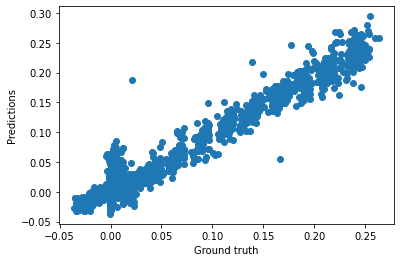

In [24]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [25]:
#%store model_rl_relative_swinging_x

In [26]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [27]:
# Save model
#joblib.dump(model_rl_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rl_relative_swinging_x.sav")

### Predict RL foot -> y

In [29]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # prev velocity command
               X_motion_RL_swinging[:, -3:], # commanded velocity command
               X_motion_RL_swinging[:, 3:9],
               X_motion_RL_swinging[:, 9:11], # FL (x,y) position
               X_motion_RL_swinging[:, 12:14], # FR (x,y) position
               X_motion_RL_swinging[:, 15:17], # RL (x,y) position
               X_motion_RL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_y = LinearRegression()

# Fit the model
model_rl_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9091252464518147
RMSE:  0.013535906975147803
The lowest error is:  4.164551854802818e-06
The highest error is:  0.14731826708678067
The avg. error is:  0.008639756550743026


In [30]:
model_rl_relative_swinging_y.coef_

array([[-1.92790268e-02, -8.44765893e-03, -3.29994904e-02,
        -3.69226941e-04,  2.27983385e-01, -2.15071618e-02,
         5.30934353e-02,  4.30829639e-03,  7.55640736e-02,
         6.79236893e-02,  1.34599522e-01, -2.88588348e-02,
        -6.95632341e-02, -3.95524029e-01,  1.92878172e-01,
        -9.45800737e-02,  1.24288387e-01, -1.32228356e-01,
        -8.41168550e-02, -3.43558842e-01]])

In [31]:
model_rl_relative_swinging_y.intercept_

array([0.00165518])

Text(0, 0.5, 'Predictions')

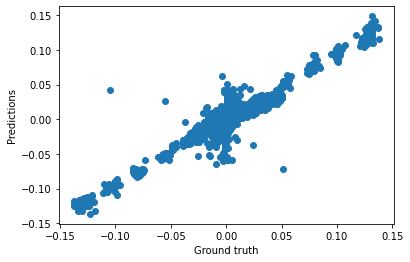

In [32]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#%store model_rl_relative_swinging_y

In [74]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [75]:
# Save model
#joblib.dump(model_rl_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rl_relative_swinging_y.sav")